In [379]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import os

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def shuffle_batch(X_data,y_data,batch_size):
    rand=np.random.permutation(len(X_data))
    n_batches=len(X_data)//batch_size
    for batch in np.array_split(rand,n_batches):
        X_batch=X_data[batch]
        y_batch=y_data[batch]
        yield X_batch,y_batch

In [397]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

def prepare_data(iddata_dir):
    X=[]
    y=[]
    correct_dir=iddata_dir+r'\Correct'
    reverse_dir=iddata_dir+r'\Reversed'
    anticlock_dir=iddata_dir+r'\Anticlockwise'
    clockwise_dir=iddata_dir+r'\Clockwise'
    
    for dir in os.listdir(correct_dir):
        X.append(cv2.resize(cv2.imread(correct_dir+'\\'+dir),(512,512)))
        y.append(0)
    
    for dir in os.listdir(reverse_dir):
        X.append(cv2.resize(cv2.imread(reverse_dir+'\\'+dir),(512,512)))
        y.append(1)
        
    for dir in os.listdir(anticlock_dir):
        X.append(cv2.resize(cv2.imread(anticlock_dir+'\\'+dir),(512,512)))
        y.append(2)
        
    for dir in os.listdir(clockwise_dir):
        X.append(cv2.resize(cv2.imread(clockwise_dir+'\\'+dir),(512,512)))
        y.append(3)
        
    X_res,y_res=shuffle(X,y)
        
    return np.array(X_res)[...,::-1],np.array(y_res)
    
    

In [398]:
X_train,y_train=prepare_data(r'C:\Users\louis\Downloads\IDdata')

0 16 (512, 512, 3)


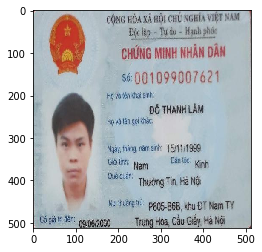

In [400]:
print(y_train[1],len(X_train),X_train[0].shape)
plt.imshow(X_train[1])


In [401]:
reset_graph()

X=tf.placeholder(tf.float32,shape=[None,512,512,3],name='X')
y=tf.placeholder(tf.int32,shape=[None],name='y')

In [402]:
with tf.name_scope('layers'):
    conv1_1=tf.layers.conv2d(X,filters=8,kernel_size=3,strides=1,padding='SAME',name='conv1_1')
    conv1_2=tf.layers.conv2d(conv1_1,filters=8,kernel_size=3,strides=1,padding='SAME',name='conv1_2')
    pool1=tf.nn.max_pool(conv1_2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    
    conv2_1=tf.layers.conv2d(pool1,filters=16,kernel_size=3,strides=1,padding='SAME',name='conv2_1')
    conv2_2=tf.layers.conv2d(conv2_1,filters=16,kernel_size=3,strides=1,padding='SAME',name='conv2_2')
    pool2=tf.nn.max_pool(conv2_2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    
    conv3_1=tf.layers.conv2d(pool2,filters=32,kernel_size=3,strides=1,padding='SAME',name='conv3_1')
    conv3_2=tf.layers.conv2d(conv3_1,filters=32,kernel_size=3,strides=1,padding='SAME',name='conv3_2')
    pool3=tf.nn.max_pool(conv3_2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    
    pool3_reshaped=tf.reshape(pool3,shape=[-1,32*64*64])
    
    

In [403]:
with tf.name_scope('fc'):
    hidden1=tf.layers.dense(pool3_reshaped,64,activation=tf.nn.relu,name='hidden1')
    logits=tf.layers.dense(hidden1,4,name='outputs')

In [404]:
with tf.name_scope('train'):
    xentropy=tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=y)
    loss=tf.reduce_mean(xentropy)
    correct=tf.nn.in_top_k(logits,y,1)
    accuracy=tf.reduce_mean(tf.cast(correct,tf.float32))
    optimizer=tf.train.AdamOptimizer()
    training_op=optimizer.minimize(loss)

In [405]:
classes={0:'correct',1:'reversed',2:'anticlockwise',3:'clockwise'}

init=tf.global_variables_initializer()
model_var=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
saver=tf.train.Saver(model_var)
n_epochs=30
batch_size=16

In [406]:
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for X_batch,y_batch in shuffle_batch(X_train,y_train,batch_size):
            sess.run(training_op,feed_dict={X:X_batch,y:y_batch})
        loss_val,acc=sess.run([loss,accuracy],feed_dict={X:X_batch,y:y_batch})
        print('epoch {} loss = {} accuracy = {}'.format(epoch,loss_val,acc))
    saver.save(sess,"./my_model_final_flipping.ckpt")

epoch 0 loss = 7954.06298828125 accuracy = 0.25
epoch 1 loss = 3478.793212890625 accuracy = 0.25
epoch 2 loss = 7459.4833984375 accuracy = 0.25
epoch 3 loss = 2202.829345703125 accuracy = 0.25
epoch 4 loss = 859.33935546875 accuracy = 0.5
epoch 5 loss = 577.9853515625 accuracy = 0.5
epoch 6 loss = 330.17041015625 accuracy = 0.75
epoch 7 loss = 74.82032775878906 accuracy = 0.75
epoch 8 loss = 52.472938537597656 accuracy = 0.75
epoch 9 loss = 115.40328979492188 accuracy = 0.6875
epoch 10 loss = 28.21390151977539 accuracy = 0.6875
epoch 11 loss = 0.07881873846054077 accuracy = 0.9375
epoch 12 loss = 0.0 accuracy = 1.0
epoch 13 loss = 0.0 accuracy = 1.0
epoch 14 loss = 0.0 accuracy = 1.0
epoch 15 loss = 0.0 accuracy = 1.0
epoch 16 loss = 0.0 accuracy = 1.0
epoch 17 loss = 0.0 accuracy = 1.0
epoch 18 loss = 0.0 accuracy = 1.0
epoch 19 loss = 0.0 accuracy = 1.0
epoch 20 loss = 0.0 accuracy = 1.0
epoch 21 loss = 0.0 accuracy = 1.0
epoch 22 loss = 0.0 accuracy = 1.0
epoch 23 loss = 0.0 accurac

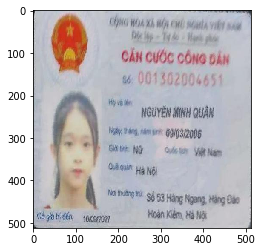

In [407]:
#test_pic=cv2.imread(r'C:\Users\louis\Downloads\IDdata\Correct\correct5.jpg')
#test_pic=cv2.resize(test_pic,(512,512))
test_pic=cv2.cvtColor(test_pic,cv2.COLOR_BGR2RGB)
plt.imshow(test_pic)

In [410]:
with tf.Session() as sess:
    saver.restore(sess,"./my_model_final_flipping.ckpt")
    y_prob=tf.nn.softmax(logits.eval({X:test_pic.reshape(1,512,512,3)}))
    y_pred=np.argmax(y_prob.eval(),axis=1)
    print(classes[y_pred[0]])

correct


In [365]:
test_pic=None